In [149]:
from pymongo import MongoClient
from tweets_utils import *
import html2text
from langdetect import detect
import re
from html import unescape
from nlumtp.preprocessors.cleaners.whitelist import CleanChars
import time
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from operator import itemgetter
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(5,3)
import numpy as np
from frozendict import frozendict
import hdbscan
import numpy as np
from html import escape
from os import listdir, makedirs
from os.path import isfile, join
import string
import re
import jellyfish
from tldextract import tldextract

In [3]:
client = MongoClient()
db = client.search_subject
real_urls_collection = db.real_urls

In [19]:
def csv_to_list_dict(path):
    df = pd.read_csv(path)
    return Counter({x["word"]: x["idf"] for x in df.to_dict(orient="records")})

allowed_languages = [('fr', 'french'), ('en', 'english')]
idf_dict = {}
idf_dict_ng = {}
for lang, lang_long in allowed_languages:
    idf_dict[lang] = csv_to_list_dict("../../datas/idf-dict-wiki-" + lang + "-nosw.csv")
    idf_dict_ng[lang] = csv_to_list_dict("../../datas/idf-dict-wiki-ngrams-" + lang + "-nosw.csv")

In [5]:
real_urls_collection.count({"txt_lang": "en"})

1250

In [6]:
max_idf = 20

In [153]:
all_urls = real_urls_collection.find({"txt_lang": "en", "txt_len": {"$gt": 350}})#, "idf_ngram": {"$size": 20}})
print("NB of URL:", all_urls.count())
clean_urls = []
words = Counter()
phrases = Counter()
max_cluster_id = next(real_urls_collection.find().sort("cluster_id", -1).limit(1))["cluster_id"] + 1
ngrams_by_clusters = [[] for x in range(max_cluster_id)]
seen_clusters = set()
num_docs = 0
for u in all_urls:
    cid = u.get("cluster_id", -1)
    
    if cid < 0 or cid not in seen_clusters:
        words.update(u.get("idf_word", set()))
        phrases.update(u.get("idf_ngram", set()))
        clean_urls.append({
                "url": u["_id"]["real_url"], 
                "words": u.get("idf_word", [])[:max_idf],  
                "words_w": u.get("idf_word_weights", [])[:max_idf], 
                "ngrams": u.get("idf_ngram", [])[:max_idf],
                "ngrams_w": u.get("idf_ngram_weights", [])[:max_idf],
                "ngrams_dict": {k: v / idf_dict_ng["en"][k] for k, v in zip(u.get("idf_ngram", [])[:max_idf], u.get("idf_ngram_weights", [])[:max_idf])},
                "title": u["txt_title"],
                "filename": u["filename"].split('.')[0],
                "cluster_id": cid
                          })
        num_docs += 1
    if cid >= 0:
        ngrams_by_clusters[cid].append((u["_id"]["real_url"], set(u["idf_ngram"])))
        seen_clusters.add(cid)
print("NB of clusters (including alone vertices):", len(clean_urls))

NB of URL: 1184
NB of clusters (including alone vertices): 748


Check if clusters with urls containing different ngrams are good (they are)

In [17]:
for i, c in enumerate(ngrams_by_clusters):
    if len(c) == 0: continue
    u, idf = zip(*c)
    inter = set.intersection(*idf)
    min_len = min(len(x) for x in idf)
    max_len = max(len(x) for x in idf)
    if len(inter) < min_len - 3:
        for x in u:
            print(x)
        print("Min: {:3} Max: {:3} Inter: {:4}".format(min_len, max_len, len(inter)))
        print()

https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/?utm_content=buffer9bfe5&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/#.WFNKsC6j9aE.twitter
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/#disqus_thread
https://medium.com/@tryolabs/the-major-advancements-in-deep-learning-in-2016-98de0feb164a
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/?utm_content=buffer25a22&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/?utm_content=buffer072d1&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
https://topdata.news/nice-article-summarizing-some-of-the-advancement-made-in-deep-learning-in-2016/
https://tryolabs.com/blog/2016/12/06/major-advancements-deep-le

NGrams divergences inside each cluster:

In [18]:
for i, c in enumerate(ngrams_by_clusters):
    if len(c) == 0: continue
    u, idf = zip(*c)
    inter = set.intersection(*idf)
    union = set.union(*idf)
    
    print(len(c), union - inter)
    print()

2 set()

16 set()

2 set()

3 set()

4 set()

48 set()

2 set()

3 set()

3 {'common sense', 'john glover'}

3 set()

4 {'salon des', 'corinna cortes', 'don t think', 'paris salon', 'technical analysis', 'bob williamson'}

12 set()

7 {'jeremy howard', 'neural networks', 'master s degree', 'machine learning', 'sofia university', 'up to speed', 'learning curve', 'high school', 'if i m honest', 'one other', 'executive director', 'change the world'}

2 set()

2 set()

2 set()

3 {'subject to change'}

12 {'textual entailment', 'part of speech tagging', 'target language', 'neural networks', 'need to', 'part of speech', 'data compression', 'shallow parsing', 'reinforcement learning', 'parts of speech', 'learning community', 'natural language processing', 'a step further'}

3 set()

2 {'machine learning', 'artificial intelligence'}

2 {'need to', 'take the', 'pdf format', 'graduate student', 'five years', 'panel discussion', 'bayesian analysis'}

3 set()

14 set()

5 {'data science'}

3 {'sp

Local IDF:

In [20]:
idf_local = {k: np.log(num_docs/phrases[k]) for k in phrases}    

In [21]:
idf_local["deep learning"], idf_dict_ng["en"]["deep learning"]

(0.61942279107299036, 10.517304134951036)

In [30]:
np.mean(list(idf_local.values()))

6.2430295558056743

In [33]:
np.mean(list(idf_dict_ng["en"].values()))

12.385573788190513

Display ngrams with local idf different than global idf:

In [37]:
diff_factor = 1.5

In [70]:
non_significant = set()
for k in idf_local:
    if phrases[k] < 3: continue
    
    wl = idf_local[k] * 2
    wg = idf_dict_ng["en"][k]
    
    if wl > wg * diff_factor:
        print("X\t{:2.3f}\t{:50}\t{:2.3f}".format(wl, k, wg))
    elif wg > wl * diff_factor:
        print("\t{:2.3f}\t{:50}\t{:2.3f}\tX".format(wl, k, wg))
        non_significant.add(k)

X	11.030	brand new                                         	5.719
X	11.030	nervous system                                    	6.441
X	11.030	taking over                                       	5.907
	5.704	deep neural network                               	13.491	X
X	11.030	clinical trials                                   	6.894
X	11.030	imagine that                                      	6.440
X	7.235	make it                                           	3.668
X	8.622	the other hand                                    	4.326
X	9.335	around the world                                  	4.314
X	10.008	point of view                                     	4.611
X	8.832	co founder                                        	5.248
	6.492	artificial neural networks                        	9.831	X
	2.316	neural networks                                   	8.297	X
X	10.454	graduate student                                  	6.952
	8.257	yoshua bengio                                     	14.051	X
X	10.454	goo

In [71]:
non_significant

{'andrew ng',
 'artificial intelligence',
 'artificial neural networks',
 'autonomous driving',
 'big data',
 'computer vision',
 'conference on neural information processing systems',
 'convolutional neural network',
 'data science',
 'data scientist',
 'deep learning',
 'deep neural network',
 'feature engineering',
 'generative model',
 'google brain',
 'google deepmind',
 'gradient descent',
 'image recognition',
 'long short term memory',
 'loss function',
 'machine learning',
 'meta learning',
 'nando de freitas',
 'natural language processing',
 'neural network',
 'neural networks',
 'object detection',
 'one shot learning',
 'recurrent neural network',
 'recurrent neural networks',
 'reinforcement learning',
 'self driving car',
 'self driving cars',
 'speech recognition',
 'stochastic gradient descent',
 'supervised learning',
 'training set',
 'unsupervised learning',
 'word embedding',
 'yann lecun',
 'yoshua bengio'}

In [42]:
def ps(a, b):
    keys = set(list(a.keys()) + list(b.keys()))
    return sum(a[k] * b[k] for k in keys)

In [43]:
def dist_w(a, b):
    ca = Counter({k: v * idf_local[k] / idf_dict_ng["en"][k] for k,v in zip(a["ngrams"], a["ngrams_w"])})
    cb = Counter({k: v * idf_local[k] / idf_dict_ng["en"][k] for k,v in zip(b["ngrams"], b["ngrams_w"])})
    
    dd = ps(ca, cb) / np.sqrt(ps(ca, ca) * ps(cb, cb))
    if dd == np.inf:
        return 2
    else:
        return 1 - dd

In [44]:
def dist_set(a, b, words=1, ngrams=1):
    d = 1 - (len(a["words"] & b["words"]) * words + len(a["ngrams"] & b["ngrams"]) * ngrams) / ((words + ngrams) * max_idf)
        
    return d

In [121]:
def sim_set(a, b, words=1, ngrams=1):
    s = (len(set(a["words"]) & set(b["words"])) * words + len(set(a["ngrams"]) & set(b["ngrams"]) - non_significant) * ngrams) / (words + ngrams)
    return s

In [122]:
thr = 0.05
dst_mat = np.zeros((len(clean_urls), len(clean_urls)))
for i, u in tqdm(enumerate(clean_urls)):
    for j, v in enumerate(clean_urls):
        if i >= j: 
            dst_mat[i, j] = dst_mat[j, i]
        else:
            dst_mat[i, j] = sim_set(u, v, words=0)

745it [00:04, 185.05it/s]


In [124]:
same_domain_count = 0
for i, a in enumerate(clean_urls):
    for j, b in enumerate(clean_urls):
        if j <= i: continue
        #if "cray" in a["url"]: continue
        #if "technologyreview" in a["url"] and "technologyreview" in b["url"]: continue
        s = dst_mat[i, j]
        if s == 5:
            if tldextract.extract(a["url"]).domain == tldextract.extract(b["url"]).domain:
                same_domain_count += 1
            else:
                print("{}\t{:3} {}\n\t{:3} {}\n\t{}".format(s, a["cluster_id"], a["url"], b["cluster_id"], b["url"], 
                                                            set(a["ngrams"]) & set(b["ngrams"]) - non_significant))
                print()
print("Same domain dupes:", same_domain_count)

5.0	 -1 http://dustintran.com/blog/on-model-mismatch-and-bayesian-analysis
	 -1 https://approximatebayesiancomputational.wordpress.com/introduction/
	{'markov chain', 'markov chain monte carlo', 'posterior distribution', 'monte carlo', 'bayesian inference'}

5.0	 -1 http://www.biorxiv.org/content/early/2016/12/14/094276
	 -1 https://techcrunch.com/2016/12/19/microsofts-plan-to-use-machine-learning-to-improve-eyecare-in-india/
	{'age related macular degeneration', 'image analysis', 'computer aided', 'macular degeneration', 'computer aided diagnosis'}

5.0	180 http://www.roboticstrends.com/article/lg_debuting_deep_learning_robots_appliances_at_ces
	 -1 https://www.koreatimes.co.kr/www/news/tech/2016/12/133_220801.html
	{'smart home', 'las vegas', 'learning technology', 'home appliances', 'lg electronics'}

5.0	221 https://www.technologyreview.com/s/602958/an-ai-ophthalmologist-shows-how-machine-learning-may-transform-medicine/?utm_content=buffer08711&utm_medium=social&utm_source=twitter.

Conclusion: if the urls are from the same site (even with different tld), it's probably the bio or boilerplate. This could be used to remove the boilerplate from the extracted content. If they are not, it's probably missed quasi equal dedup for s > 6 threshold. For s <= 6 we start to see stories but also fake positives.

##### Similarity distribution: everything is far apart

In [131]:
dst_flat = np.array([q for p in dst_mat for q in p])

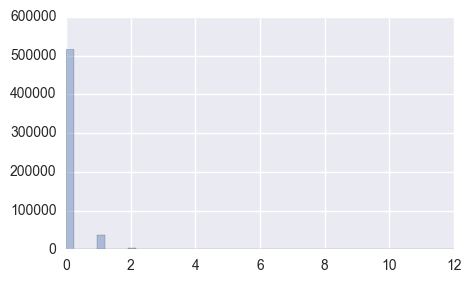

In [150]:
sns.distplot(dst_flat, kde=False)

### Sim local idf distance

In [167]:
def sim_local_idf(a, b):
    inter = set(a["ngrams"]) & set(b["ngrams"]) - non_significant
    s = sum(idf_local[k] for w in inter)
    return s

In [168]:
thr = 0.05
dst_mat = np.zeros((len(clean_urls), len(clean_urls)))
for i, u in tqdm(enumerate(clean_urls)):
    for j, v in enumerate(clean_urls):
        if i >= j: 
            dst_mat[i, j] = dst_mat[j, i]
        else:
            dst_mat[i, j] = sim_local_idf(u, v)

748it [00:02, 280.05it/s]


In [169]:
dst_flat = np.array([q for p in dst_mat for q in p])

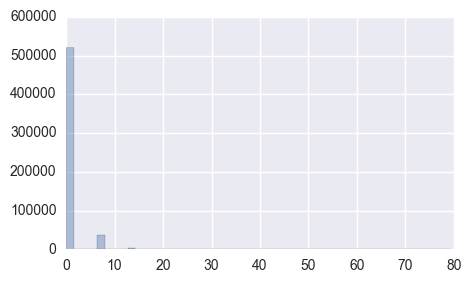

In [170]:
sns.distplot(dst_flat, kde=False)

In [180]:
same_domain_count = 0
for i, a in enumerate(clean_urls):
    for j, b in enumerate(clean_urls):
        if j <= i: continue
        if "cray" in a["url"]: continue
        if "technologyreview" in a["url"] and "technologyreview" in b["url"]: continue
        s = dst_mat[i, j]
        if s // 10 == 2:
            if tldextract.extract(a["url"]).domain == tldextract.extract(b["url"]).domain:
                same_domain_count += 1
            else:
                print("{}\t{:3} {}\n\t{:3} {}\n\t{}".format(int(s), a["cluster_id"], a["url"], b["cluster_id"], b["url"], 
                                                            set(a["ngrams"]) & set(b["ngrams"]) - non_significant))
                print()
print("Same domain dupes:", same_domain_count)

26	 -1 http://www.jennwv.com/projects/crowdtutorial.html
	 -1 http://crowdml.cc/nips2016/
	{'human computation', 'mechanical turk', 'learning theory', 'amazon mechanical turk'}

26	 -1 http://www.jobs.ac.uk/job/AVV792/lectureship-senior-lectureship-in-artificial-intelligence-and-machine-learning/
	 -1 http://www.uva.nl/en/about-the-uva/working-at-the-uva/vacancies/item/16-580-10-phd-candidates-or-postdoctoral-researchers-in-machine-learning-and-deep-learning.html
	{'tenure track', 'full time', 'computer science', 'academic research'}

26	 28 http://abunchofdata.com/videos-at-nips2016-and-other-news-and-announcements/
	135 http://nuit-blanche.blogspot.com/2016/12/spotlight-videos-at-nips2016.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+blogspot%2FvhVI+%28Nuit+Blanche%29
	{'facebook page', 'the big picture', 'there s more where that came from', 'nuit blanche'}

26	 30 https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/
	129 http://chatbotslif

### Make clusters based on ngrams & words

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, metric="precomputed")

In [141]:
results = clusterer.fit_predict(dists)

In [142]:
r = {group: [] for group in results}    

for i, group in enumerate(results):
    r[group].append(clean_urls[i])

In [144]:
with open("urls-cluster.html", 'w') as f:
    f.write('<p>')
    for group in r:
        if group == -1:
            continue
            
        words = set(r[group][0]["words"])
        ngrams = set(r[group][0]["ngrams"])
        for url in r[group]:
            words = words & url["words"]
            ngrams = ngrams & url["ngrams"]
        f.write("Group:{}<br/>Words: {}<br/>Ngrams: {}<br/>".format(str(group), str(words), str(ngrams)))
        for url in r[group]:
            f.write("{}<br/>&nbsp;&nbsp;&nbsp;<a href={}>{}</a><br />".format(escape(url["title"])[:100] if url["title"] is not None else "NO TITLE" , url["url"], url["url"]))
        f.write('<br/><br/><br/>')
    f.write('</p>')